**Predicting the price of stocks of IBM**

In [19]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
from keras.optimizers import SGD
import math
from sklearn.metrics import mean_squared_error

In [20]:
def plot_predictions(test,predicted):
    plt.plot(test, color='red',label='Real IBM Stock Price')
    plt.plot(predicted, color='blue',label='Predicted IBM Stock Price')
    plt.title('IBM Stock Price Prediction')
    plt.xlabel('Time')
    plt.ylabel('IBM Stock Price')
    plt.legend()
    plt.show()

def return_rmse(test,predicted):
    rmse = math.sqrt(mean_squared_error(test, predicted))
    print("The root mean squared error is {}.".format(rmse))

In [21]:
# Toget the data
dataset = pd.read_csv('IBM_Dataset.csv', index_col='Date', parse_dates=['Date'])
dataset.head()

,Open,High,Low,Close,Volume,Name
Date,,,,,,
2006-01-03,82.45,82.55,80.81,82.06,11715200,IBM
2006-01-04,82.20,82.50,81.33,81.95,9840600,IBM
2006-01-05,81.40,82.90,81.00,82.50,7213500,IBM
2006-01-06,83.95,85.03,83.41,84.95,8197400,IBM
2006-01-09,84.10,84.25,83.38,83.73,6858200,IBM


In [22]:
# Checking for missing values
training_set = dataset[:'2016'].iloc[:,1:2].values
test_set = dataset['2017':].iloc[:,1:2].values

print("Missing values in training set:")
print(dataset.isnull().sum())

Missing values in training set:
Open      1
High      0
Low       1
Close     0
Volume    0
Name      0
dtype: int64


In [23]:
# fill missing values
dataset['Open'].fillna(dataset['Open'].mean(), inplace=True)
dataset['Low'].fillna(dataset['Low'].mean(), inplace=True)

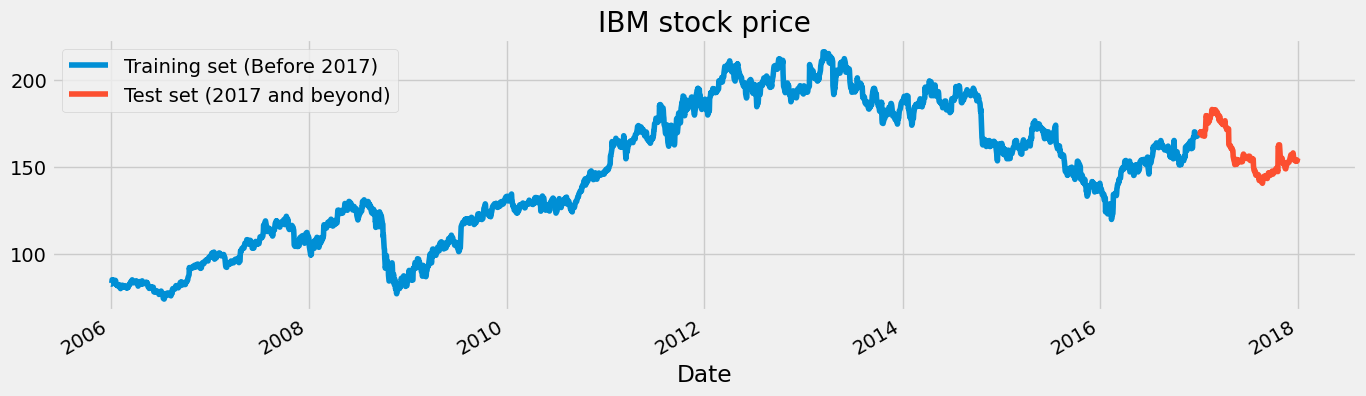

In [24]:
# We have chosen 'High' attribute for prices. Let's see what it looks like
dataset["High"][:'2016'].plot(figsize=(15,4),legend=True)
dataset["High"]['2017':].plot(figsize=(15,4),legend=True)
plt.legend(['Training set (Before 2017)','Test set (2017 and beyond)'])
plt.title('IBM stock price')
plt.show()

In [25]:
# Scaling the training set
sc = MinMaxScaler(feature_range=(0,1))
training_set_scaled = sc.fit_transform(training_set)

In [26]:
training_set_scaled

array([[0.06065089],
       [0.06029868],
       [0.06311637],
       ...,
       [0.66074951],
       [0.65546633],
       [0.6534235 ]])

In [27]:
# Since LSTMs store long term memory state, we create a data structure with 60 timesteps and 1 output
# So for each element of training set, we have 60 previous training set elements
X_train = []
y_train = []
for i in range(60,2769):
    X_train.append(training_set_scaled[i-60:i,0])
    y_train.append(training_set_scaled[i,0])
X_train, y_train = np.array(X_train), np.array(y_train)

In [28]:
X_train

array([[0.06065089, 0.06029868, 0.06311637, ..., 0.0656523 , 0.06656805,
        0.06769513],
       [0.06029868, 0.06311637, 0.0781206 , ..., 0.06656805, 0.06769513,
        0.06875176],
       [0.06311637, 0.0781206 , 0.07262609, ..., 0.06769513, 0.06875176,
        0.06804734],
       ...,
       [0.594745  , 0.59587208, 0.59094111, ..., 0.66420118, 0.65898845,
        0.66244012],
       [0.59587208, 0.59094111, 0.58812342, ..., 0.65898845, 0.66244012,
        0.66074951],
       [0.59094111, 0.58812342, 0.59002536, ..., 0.66244012, 0.66074951,
        0.65546633]])

In [29]:
y_train

array([0.06875176, 0.06804734, 0.06797689, ..., 0.66074951, 0.65546633,
       0.6534235 ])

In [30]:
# Reshaping X_train for efficient modelling
X_train = np.reshape(X_train, (X_train.shape[0],X_train.shape[1],1))

In [31]:
# The LSTM architecture

regressor = Sequential()
# First LSTM layer with Dropout regularisation
regressor.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],1)))
regressor.add(Dropout(0.2))
# Second LSTM layer
regressor.add(LSTM(units=50, return_sequences=True))
regressor.add(Dropout(0.2))
# Third LSTM layer
regressor.add(LSTM(units=50, return_sequences=True))
regressor.add(Dropout(0.2))
# Fourth LSTM layer
regressor.add(LSTM(units=50))
regressor.add(Dropout(0.2))
# The output layer
regressor.add(Dense(units=1))

# Compiling the RNN
regressor.compile(optimizer='adam',loss='mean_squared_error')
# Fitting to the training set
regressor.fit(X_train,y_train,epochs=50,batch_size=32)

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


85/85 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - loss: 0.0711
Epoch 2/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.0058
Epoch 3/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0047
Epoch 4/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0044
Epoch 5/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.0041
Epoch 6/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0040
Epoch 7/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0035
Epoch 8/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0034
Epoch 9/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0035
Epoch 10/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.0035
Epoch 11/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.0029
Epoch 12/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0030
Epoch 13/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0028
Epoch 14/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0026
Epoch 15/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0025
Epoch 16/50
85/

In [32]:
# Now to get the test set ready in a similar way as the training set.
# The following has been done so first 60 entires of test set have 60 previous values which is impossible to get unless we take the whole
# 'High' attribute data for processing
dataset_total = pd.concat((dataset["High"][:'2016'],dataset["High"]['2017':]),axis=0)
inputs = dataset_total[len(dataset_total)-len(test_set) - 60:].values
inputs = inputs.reshape(-1,1)
inputs  = sc.transform(inputs)

In [33]:
# Preparing X_test and predicting the prices
X_test = []
for i in range(60,311):
    X_test.append(inputs[i-60:i,0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
predicted_stock_price = regressor.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step


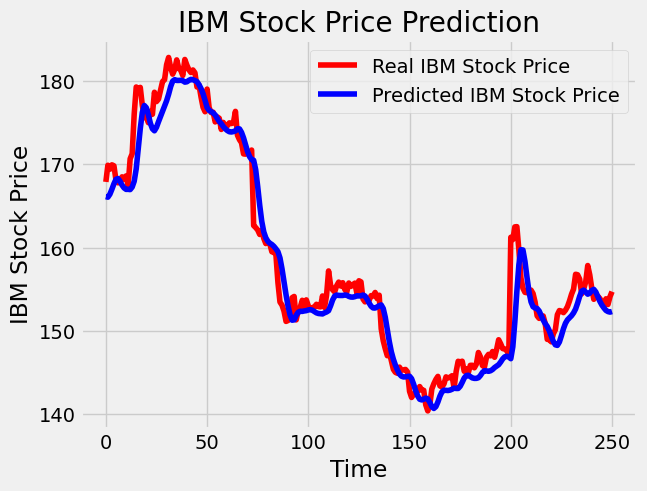

In [34]:
# Visualizing the results for LSTM
plot_predictions(test_set,predicted_stock_price)

In [48]:
# Evaluating our model
lstm_rmse = return_rmse(test_set,predicted_stock_price)

The root mean squared error is 2.680459943578152.


**Gated Recurrent Units(GRU)**

In [37]:
# The GRU architecture
regressorGRU = Sequential()

# First GRU layer with Dropout regularisation
regressorGRU.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
regressorGRU.add(Dropout(0.2))
# Second GRU layer
regressorGRU.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
regressorGRU.add(Dropout(0.2))
# Third GRU layer
regressorGRU.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
regressorGRU.add(Dropout(0.2))
# Fourth GRU layer
regressorGRU.add(GRU(units=50, activation='tanh'))
regressorGRU.add(Dropout(0.2))
# The output layer
regressorGRU.add(Dense(units=1))
# Compiling the RNN
regressorGRU.compile(optimizer=SGD(learning_rate=0.01, decay=1e-7, momentum=0.9, nesterov=False),loss='mean_squared_error')
# Fitting to the training set
regressorGRU.fit(X_train,y_train,epochs=50,batch_size=150)

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 0.1943
Epoch 2/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0753
Epoch 3/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0316
Epoch 4/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0107
Epoch 5/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0050
Epoch 6/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0043
Epoch 7/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0035
Epoch 8/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0038
Epoch 9/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0034
Epoch 10/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0032
Epoch 11/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0032
Epoch 12/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0029
Epoch 13/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0031
Epoch 14/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0028
Epoch 15/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0029
Epoch 16/50
19/

In [38]:
# Preparing X_test and predicting the prices
X_test = []
for i in range(60,311):
    X_test.append(inputs[i-60:i,0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
GRU_predicted_stock_price = regressorGRU.predict(X_test)
GRU_predicted_stock_price = sc.inverse_transform(GRU_predicted_stock_price)

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step


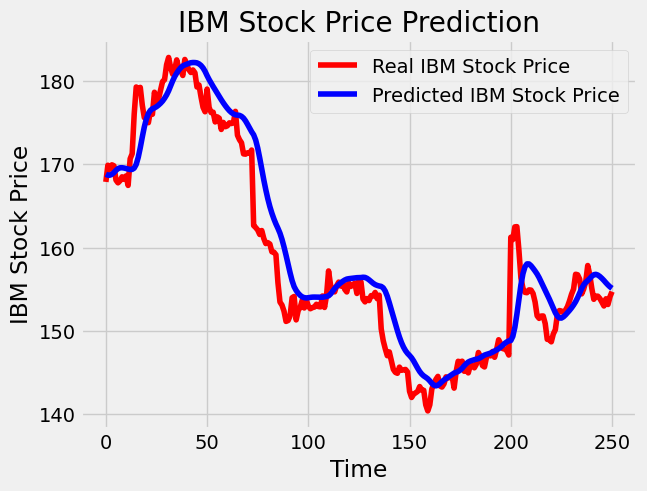

In [39]:
# Visualizing the results for GRU
plot_predictions(test_set,GRU_predicted_stock_price)

In [49]:
# Evaluating GRU
gru_rmse = return_rmse(test_set,GRU_predicted_stock_price)

The root mean squared error is 3.549508633208551.


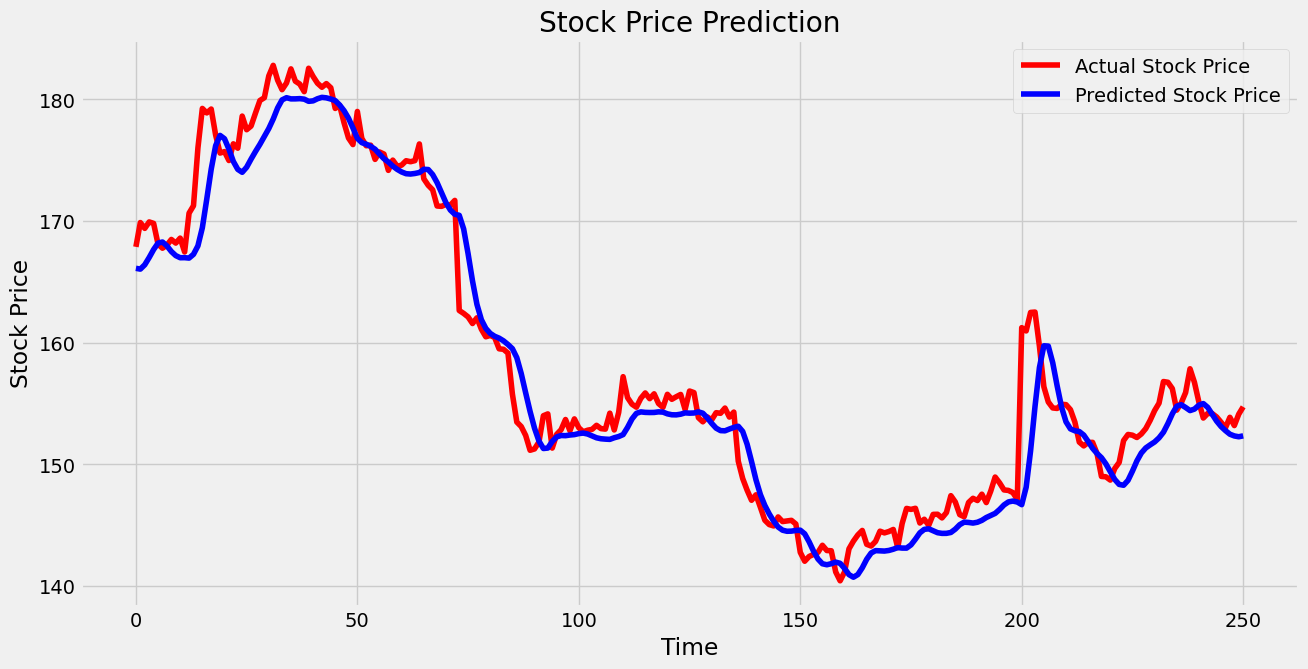

In [47]:
import matplotlib.pyplot as plt

# Plot results
plt.figure(figsize=(14, 7))

# Plot actual vs. predicted prices
plt.plot(test_set, color='red', label='Actual Stock Price')
plt.plot(predicted_stock_price, color='blue', label='Predicted Stock Price')

plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()
